In [93]:
# !pip install gingado fredapi ruptures

# !pip install -U 'spacy[apple]'
# # !pip install -U 'spacy[cuda12x]'

In [94]:
import os
from dotenv import load_dotenv; load_dotenv()
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import json
import re
import unicodedata
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
import spacy; spacy.prefer_gpu()
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gingado.datasets import load_CB_speeches
from fredapi import Fred
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from sklearn.decomposition import PCA
import ruptures as rpt
import matplotlib.pyplot as plt
from src.openai_api import chat_completion as openai_chat
from src.google_ai_api import chat_completion as googleai_chat

In [95]:
DATA_PATH = os.getenv("DATA_PATH")
FRED_API = os.getenv("FRED_API_KEY")
DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

START_DATE = '1996-01-01'
END_DATE = '2025-05-01'

# Helpers

In [96]:
def install_spacy_model(lang: str="en", pipeline_for: str="sm"):
    """
    Install the spacy model for the specified language and pipeline.

    Args:
        lang (str): Language code (default: "en").
        pipeline_for (str): Pipeline type ("sm" for efficiency, "trf" for accuracy).

    Returns:
        str: The name of the installed spacy model.
    """
    pipeline_name = f"{lang}_core_web_{pipeline_for}"

    try:
        _ = spacy.load(pipeline_name)
    except Exception as e:
        print(f"Error loading spacy model: {e}")
        print("Downloading spacy model...")
        os.system(f"python -m spacy download {pipeline_name}")
        try:
            _ = spacy.load(pipeline_name)
        except Exception as e:
            print(f"Error loading spacy model persists.")
            raise e

In [97]:
def softmax(x, T=1):
    x = x / T
    return np.exp(x) / np.sum(np.exp(x))

In [98]:
def sigmoid(p1, p0, k):
    return 1 / ( 1 + np.exp( -k * (p1 - p0) ) )

---

# Macroeconomic indices

**Including:** FED Fund Rates, CPI, PPI, GDP, Unemployment, Nonfarm payrolls

### Getting the data

In [99]:
fred = Fred(api_key=FRED_API)

def load_data(start: str, end: str):
    
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime('today') if end is None else pd.to_datetime(end)
    if start_date > end_date:
        raise ValueError("Start date must be before end date.")
    
    start_refined = start_date.strftime('%m/%d/%Y')
    end_refined = end_date.strftime('%m/%d/%Y')

    fedrates = fred.get_series('FEDFUNDS', start_refined, end_refined)  # Federal Funds Rate from FRED
    fedrates.name = 'FED Funds Rate'

    cpi = fred.get_series('CPIAUCNS', start_refined, end_refined)  # CPI from FRED
    cpi.name = 'CPI'

    ppi = fred.get_series('PPIACO', start_refined, end_refined)  # PPI from FRED
    ppi.name = 'PPI'

    gdp = fred.get_series('GDP', start_refined, end_refined)  # GDP from FRED
    gdp.name = 'GDP'

    unemployment = fred.get_series('UNRATE', start_refined, end_refined)  # Unemployment from FRED
    unemployment.name = 'Unemployment'

    nfp = fred.get_series('PAYEMS', start_refined, end_refined)  # Nonfarm Payrolls from FRED
    nfp.name = 'Nonfarm Payrolls'

    df = pd.concat([fedrates, cpi, ppi, gdp, unemployment, nfp], axis=1)
    df = df.ffill()

    return df

In [100]:
macrodata = load_data(START_DATE, END_DATE)
macrodata['date'] = pd.to_datetime(macrodata.index)
macrodata = macrodata.reset_index(drop=True)
print(f"Found {len(macrodata)} data points, saved and loaded.")

Found 353 data points, saved and loaded.


In [101]:
macrodata_cp = macrodata.copy().dropna()
macrodata_cp = macrodata_cp.set_index('date')

macrodata_returns = macrodata_cp.pct_change()

### Scaling data

Rolling window mode

In [102]:
def rolling_window_scaling(data, window_size=12, scaler=StandardScaler()):
    scaled_data = []
    # for i in range(window_size, len(data)):
    for i in range(len(data)):
        if i < window_size:
            scaled_data.append([np.nan] * data.shape[1])
            continue
        idx = i + 1
        window_data = data[idx - window_size : idx]
        assert len(window_data) == window_size
        scaled_window = scaler.fit_transform(window_data)
        scaled_data.append(list(scaled_window[-1]))
    return np.array(scaled_data)

<Axes: title={'center': 'Scaled Macroeconomic Data (rolling window)'}, xlabel='date'>

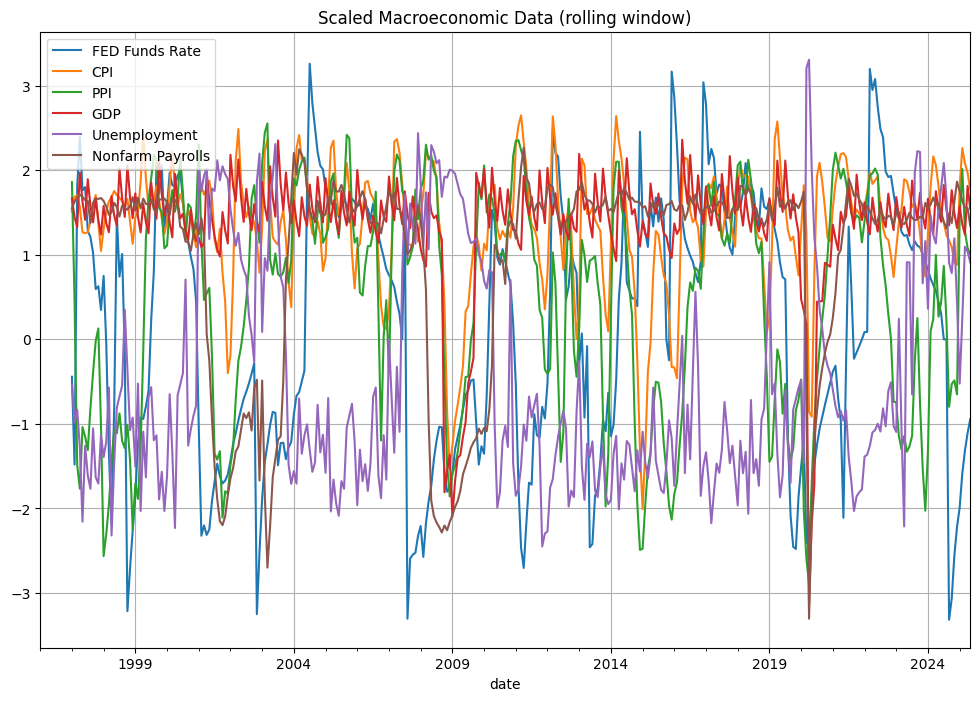

In [103]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = MaxAbsScaler()

data = macrodata_cp.values
scaled_data = rolling_window_scaling(data, window_size=12, scaler=scaler)
scaled_data_df = pd.DataFrame(scaled_data, columns=macrodata_cp.columns, index=macrodata_cp.index)

scaled_data_df.plot(figsize=(12, 8), subplots=False, title='Scaled Macroeconomic Data (rolling window)', grid=True)

In [104]:
scaled_data_df = scaled_data_df.dropna()
scaled_data = scaled_data_df.values

In [105]:
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
pca_cols = [f'PC{i+1}' for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_data, columns=pca_cols)
pca_df.index = scaled_data_df.index

In [106]:
threshold = 0.9
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components_thresh = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components explaining {round(threshold*100)}% of the variance: {n_components_thresh} (out of {scaled_data_df.shape[1]} variables)")

Number of components explaining 90% of the variance: 4 (out of 6 variables)


In [107]:
pca_loadings = pd.DataFrame(pca.components_, index=pca_cols, columns=macrodata_cp.columns).mul(100)
pca_loadings["Explained Variance"] = pca.explained_variance_ratio_ * 100
styled_df = (
    pca_loadings
    .style
    .format("{:.2f}%")
    .background_gradient(cmap='coolwarm', vmin=-100, vmax=100, axis=None, subset=pca_loadings.columns[:-1])  # Exclude last col
    .background_gradient(cmap='Greys', vmin=0, vmax=100, subset=['Explained Variance'])  # Custom for Explained Variance
    .set_properties(**{
        'font-size': '15px',
        'padding': '12px',
        'text-align': 'center'
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '18px'), ('padding', '12px')]},
        {'selector': 'td.col_heading.level0', 'props': [('border-right', 'px solid black')]},  # Optional right border
        {'selector': 'td.col_heading.level1', 'props': [('border-right', '2px solid black')]}
    ])
)
styled_df

,FED Funds Rate,CPI,PPI,GDP,Unemployment,Nonfarm Payrolls,Explained Variance
PC1,61.19%,11.26%,20.61%,17.35%,-55.83%,47.81%,48.52%
PC2,-30.96%,35.05%,87.01%,13.43%,7.55%,-2.19%,23.05%
PC3,71.89%,-5.61%,24.92%,-12.90%,43.09%,-46.43%,15.36%
PC4,9.97%,33.08%,-20.70%,42.20%,64.90%,48.84%,6.41%
PC5,2.67%,43.83%,-24.96%,59.57%,-27.10%,-56.26%,3.97%
PC6,4.71%,74.82%,-18.22%,-63.42%,-4.72%,1.72%,2.69%


We performed a naive PCA on the standardized macroeconomic indicators without pre-selecting the number of components. We PCA using the following macroeconomic variables:
- **FED Funds Rate** (Policy)
- **CPI**, **PPI** (Inflation)
- **GDP** (Growth/Output)
- **Unemployment**, **Nonfarm Payrolls** (Labor)

<!-- ---

### ✅ PC1 — Monetary Tightening & Labor Market Strength
- **High positive loadings**:
  - FED Funds Rate, Nonfarm Payrolls
- **Strong negative loading**:
  - Unemployment
- **Moderate positive**:
  - GDP, PPI
- **Interpretation**: A clear **expansion-tightening** dimension. Reflects **strong macro + policy response**. Suitable as a **composite macroeconomic strength index**.

📌 **In summary**: This component captures the **macro cycle**, combining policy tightening (rate hikes), growth (employment, GDP), and low unemployment. Higher PC1 indicates **expansionary phases with policy tightening**.


### ✅ PC2 — Inflationary Pressures
- **Very high positive**: PPI, CPI
- **Moderate negative**: FED Funds Rate
- **Low loadings elsewhere**
- **Interpretation**: Reflects **raw inflation** signal decoupled from central bank action. Useful to **capture price pressure regimes**.

📌 **In summary**: Captures **price pressures from producers** not necessarily matched by central bank response. May indicate **inflationary tensions or lag in policy response**. Possibly linked to **commodity shocks**.


### 🔎 PC3 — Policy/Labor Conflict
- **Strong positive**: FED Funds Rate, Unemployment
- **Strong negative**: Nonfarm Payrolls
- **Mild positive**: GDP
- **Interpretation**: Captures **policy pressure amid labor weakness**. May highlight **policy mistake risk or stagflation setup**.

📌 **In summary**: Indicates a **policy-tightening regime associated with labor market weakening**. Possibly reflects periods of **restrictive policy responses to overheating**, or early-cycle slowdowns.


### ❌ PC4 — Diffuse
- **Positive**: CPI, GDP, Unemployment, Payrolls
- **Negative**: PPI
- **Interpretation**: More diffuse. Potentially **reflation narrative** (rising output & prices) with **mixed labor implications**.
- **Weak macro signal**, but could be monitored.

📌 **In summary**: Captures broad-based **real economic strength**, with synchronized improvements in employment, output, and prices. Could reflect **recovery phases** or **sustained expansions**.


### 🔎 PC5 — Growth-Payroll Divergence
- **Positive**: GDP, CPI
- **Strong negative**: Payrolls, PPI
- **Interpretation**: Captures periods where **growth and employment diverge**, possibly post-shock recoveries or measurement frictions.

📌 **In summary**: Suggests **decoupling between GDP and labor market**. Possibly reflects **productivity gains**, **automation**, or **jobless recoveries**.


### ❌ PC6 — CPI-Only Shock
- **Single strong positive**: CPI
- All other variables low or negative
- **Interpretation**: Looks like **noise or isolated CPI movement**. Not structurally useful.

📌 **In Summary**: Captures episodes of **high consumer inflation amid economic slowdown**. Potentially reflects **stagflation-like scenarios** or **supply-driven inflation** with weak growth.


--- -->

### Index Construction
- **PC1**: Core macro–policy strength signal (main index)
- **PC2**: Orthogonal inflation dimension
- **PC3**: Labor–policy divergence (optional)
- **PC5**: Growth-Payroll Divergence (optional)


<!-- | PC  | Dominant Theme                    | Key Variables                          |
|-----|----------------------------------|----------------------------------------|
| PC1 | Macro Expansion / Tightening     | FED Rate ↑, NFP ↑, Unemp ↓             |
| PC2 | Cost Inflation Pressure          | PPI ↑, CPI ↑, FED Rate ↓               |
| PC3 | Policy vs Labor Conflict         | FED Rate ↑, Unemp ↑, NFP ↓             |
| PC4 | Real Growth Recovery             | GDP ↑, NFP ↑, Unemp ↑                  |
| PC5 | GDP–Employment Decoupling        | GDP ↑, CPI ↑, NFP ↓, Unemp ↓           |
| PC6 | Stagflation / CPI vs Growth      | CPI ↑, GDP ↓, Unemp ↓                  | -->

---

# Change Point Detection: Macro Strength focused

In [108]:
macro_index = pca_df['PC1']
inflation_index = pca_df['PC2']

model = "rbf"

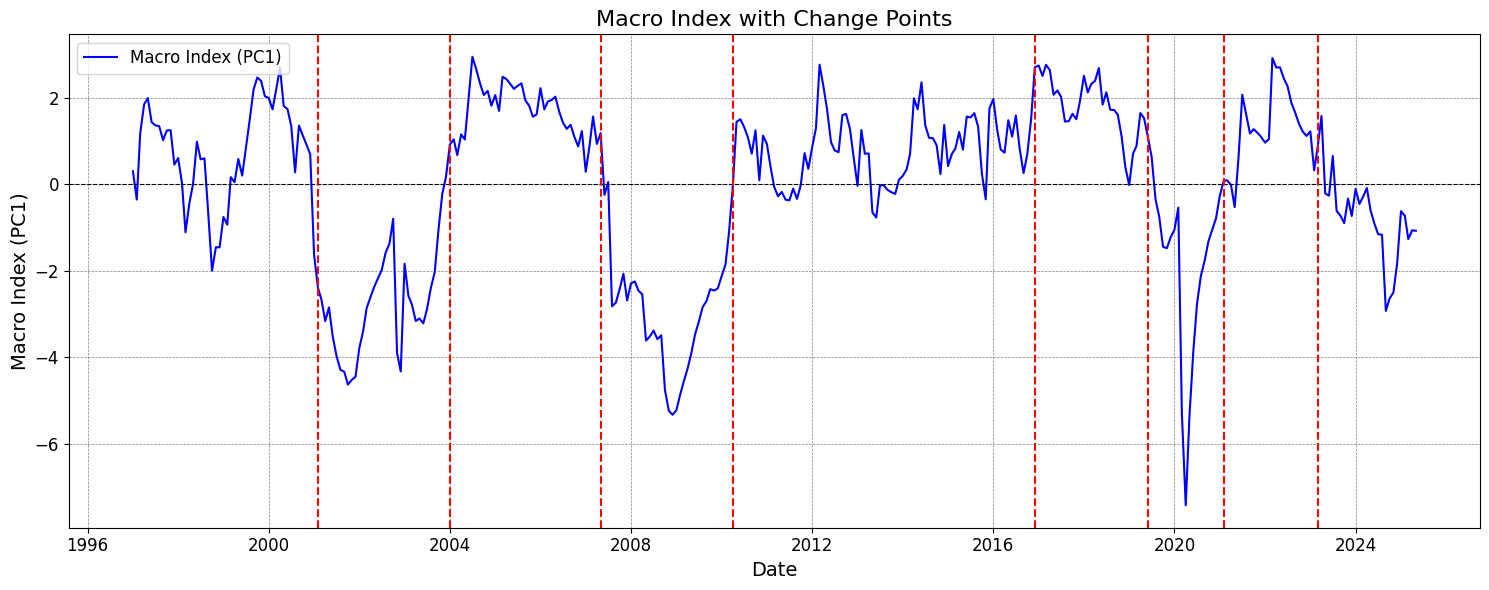

In [109]:
algo = rpt.Pelt(model=model).fit(macro_index.values)
breaks = algo.predict(pen=5)[:-1] # Penalty controls number of breaks; tune as needed
break_dates = [macro_index.index[i-1] for i in breaks]

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(macro_index.index, macro_index.values, label='Macro Index (PC1)', color='blue', linewidth=1.5)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_title('Macro Index with Change Points', fontsize=16, color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
ax.set_ylabel('Macro Index (PC1)', fontsize=14, color='black')
ax.tick_params(axis='both', labelsize=12, colors='black')
ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
ax.legend(fontsize=12, loc='upper left')
for break_date in break_dates:
    ax.axvline(x=break_date, color='red', linestyle='--', linewidth=1.5, label='Change Point')
plt.tight_layout()
plt.show()

# Text Pre-processing

### Getting data: central bankers speeches

In [110]:
"""
load_CB_speeches (year: 'str | int | list' = 'all', cache: 'bool' = True, timeout: 'float | None' = 120, **kwargs) -> 'pd.DataFrame'

Args:
    year: Either 'all' to download all available central bank speeches or the year(s)
        to download. Defaults to 'all'.
    cache: If False, cached data will be ignored and the dataset will be downloaded again.
        Defaults to True.
    timeout: The timeout to for downloading each speeches file. Set to `None` to disable
        timeout. Defaults to 120.
    **kwargs. Additional keyword arguments which will be passed to pandas `read_csv` function.

Returns:
    A pandas DataFrame containing the speeches dataset.
"""

def load_speeches(start: str, end: str = None, cache: bool = False) -> pd.DataFrame:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime('today') if end is None else pd.to_datetime(end)
    if start_date > end_date:
        raise ValueError("Start date must be before end date.")

    speeches = load_CB_speeches(year='all', cache=cache)
    speeches['date'] = pd.to_datetime(speeches['date'])
    speeches = speeches[(speeches['date'] >= start_date) & (speeches['date'] < end_date)]
    speeches = speeches.sort_values(by='date')
    speeches = speeches.reset_index(drop=True)
    return speeches

In [111]:
speeches = load_speeches(START_DATE, END_DATE)
speeches['date'] = pd.to_datetime(speeches['date'])
print(f"Found {len(speeches)} speeches, saved and loaded.")

Found 19855 speeches, saved and loaded.


### Pre-processing data

Filtering US Central Banker's speeches: using OpenAI's ChatGPT for NER

In [112]:
res_example_1 = '{ "organization": "Bank of England", "region": "UK" }'
res_example_2 = '{ "organization": "European Central Bank", "region": "EU" }'
res_example_3 = '{ "organization": "Bank of Japan", "region": "JP" }'

PROMPT_BASE = f'''Extract the organization and original region (country code when available or at least continent code-e.g. EU for Europe) of ###AUTHOR### who is the author of the speech title and description given bellow.
Return the result as a Python dictionary with the keys "organization" and "region" and the extracted corresponding values.
Result example 1: {res_example_1}
Result example 2: {res_example_2}
Result example 3: {res_example_3}
Don't add anything else, strictly adheres to example format and give the the region as two digits code, replace values by None (no brackets) if you are not able to find it.
The speech has been given on ###DATE###.
Title: "###TITLE###".
Description is: "###DESCRIPTION###".
'''

def get_prompt(title: str, description: str, author: str, date: str) -> str:
    if author is None: author = ""
    if description is None: description = ""
    if title is None: title = ""
    if date is None: date = ""

    if not isinstance(title, str): title = str(title)
    if not isinstance(description, str): description = str(description)
    if not isinstance(author, str): author = str(author)
    if not isinstance(date, str): date = str(date)

    prompt = PROMPT_BASE
    prompt = prompt.replace('###TITLE###', title)
    prompt = prompt.replace('###DESCRIPTION###', description)
    prompt = prompt.replace('###AUTHOR###', author)
    prompt = prompt.replace('###DATE###', date)
    return prompt

def get_treated_speeches(speeches: pd.DataFrame) -> pd.DataFrame:
    if not "region" in speeches.columns:
        speeches["region"] = None
    if not "organization" in speeches.columns:
        speeches["organization"] = None

    for idx, row in tqdm(speeches.iterrows(), total=len(speeches)):
        if (row['region'] is not None) and (row['organization'] is not None):
            continue
        title = row['title']
        description = row['description']
        author = row['author']
        date = row['date'].strftime('%Y-%m-%d')
        prompt = get_prompt(title, description, author, date)
        response = openai_chat(prompt=prompt, max_tokens=16384, verbose=False)
        # response = openai_chat(model="gpt-4.1-mini-2025-04-14", prompt=prompt, max_tokens=32768, verbose=False)
        # response = googleai_chat(prompt, verbose=False)
        try:
            result = json.loads(response)
            if not isinstance(result, dict):
                if isinstance(result, str):
                    try:
                        result = eval(result)
                    except:
                        print(f"Error evaluating string for author: {author}, date: {date}")
                        continue
        except json.JSONDecodeError:
            print(f"Error decoding JSON for author: {author}, date: {date}")
            continue
        if 'organization' in result:
            speeches.at[idx, 'organization'] = result['organization']
        if 'region' in result:
            speeches.at[idx, 'region'] = result['region']

    return speeches

In [113]:
fpath = os.path.join(DATA_PATH, f'gingado_central-bank-speeches_{START_DATE}_{END_DATE}-ner.csv')
if not os.path.exists(fpath):
    print(f"File not found: {fpath}")
    print("Downloading the dataset...")
    treated_speeches = get_treated_speeches(speeches)
    speeches.to_csv(fpath, index=False)
else:
    print(f"Loading existing dataset from: {fpath}")
    treated_speeches = pd.read_csv(fpath)
    treated_speeches['date'] = pd.to_datetime(treated_speeches['date'])
    
us_speeches = treated_speeches[treated_speeches['region'] == 'US'].copy().reset_index(drop=True)

print(f"Resulting in {len(us_speeches)} US speeches, loaded.")
print(int(us_speeches.groupby(us_speeches.date.dt.year).size().mean()), " average number of speeches per year")
print(us_speeches.date.min(), us_speeches.date.max())

Loading existing dataset from: /Users/tig1/Programming/TOPOL/data/gingado_central-bank-speeches_1996-01-01_2025-05-01-ner.csv
Resulting in 2342 US speeches, loaded.
78  average number of speeches per year
1996-12-19 00:00:00 2025-03-25 00:00:00


In [114]:
us_speeches

,url,title,description,date,text,author,region,organization,documents
0,https://www.bis.org/review/r970108b.pdf,Ms. Rivlin discusses the prudential regulation...,Remarks by the Vice Chairman of the Board of G...,1996-12-19,Ms. Rivlin discusses the prudential regulation...,Alice M Rivlin,US,US Federal Reserve System,Ms. Rivlin discusses the prudential regulation...
1,https://www.bis.org/review/r970108a.pdf,Mr. Meyer examines the role for structural mac...,"Remarks by Mr. Laurence H. Meyer, a member of ...",1997-01-05,Mr. Meyer examines the role for structural mac...,Laurence H Meyer,US,US Federal Reserve System,Mr. Meyer examines the role for structural mac...
2,https://www.bis.org/review/r970116.pdf,Mr. Greenspan addresses some key roles of a ce...,Remarks by the Chairman of the Board of Govern...,1997-01-14,Remarks by the\nMr. Greenspan addresses some k...,Alan Greenspan,US,US Federal Reserve System,Remarks by the Mr. Greenspan addresses some ke...
3,https://www.bis.org/review/r970121a.pdf,Mr. Meyer reviews the economic outlook and cha...,"Remarks by Mr. Laurence H. Meyer, a member of ...",1997-01-16,Mr. Meyer reviews the economic outlook and cha...,Laurence H Meyer,US,US Federal Reserve System,Mr. Meyer reviews the economic outlook and cha...
4,https://www.bis.org/review/r970122a.pdf,Mr. Greenspan gives some personal perspectives...,Testimony of the Chairman of the Board of Gove...,1997-01-21,Mr. Greenspan gives some personal perspectives...,Alan Greenspan,US,Federal Reserve System,Mr. Greenspan gives some personal perspectives...
...,...,...,...,...,...,...,...,...,...
2337,https://www.bis.org/review/r250311a.htm,"Michelle W Bowman: Remarks on ""Monetary policy...","Remarks by Ms Michelle W Bowman, Member of the...",2025-03-07,"Michelle W Bowman: Remarks on ""Monetary policy...",Michelle W Bowman,US,Federal Reserve System,"Michelle W Bowman: Remarks on ""Monetary policy..."
2338,https://www.bis.org/review/r250324c.htm,John C Williams: Certain uncertainty,"Remarks by Mr John C Williams, President and C...",2025-03-21,"Certain Uncertainty\nMarch 21, 2025\nJohn C. W...",John C Williams,US,Federal Reserve Bank of New York,"Certain Uncertainty March 21, 2025 John C. Wil..."
2339,https://www.bis.org/review/r250325c.htm,Michael S Barr: Helping small businesses reach...,"Speech by Mr Michael S Barr, Vice Chair for Su...",2025-03-24,For release on delivery\n3:10 p.m. EDT\nMarch ...,Michael S Barr,US,Federal Reserve System,For release on delivery 3:10 p.m. EDT March 24...
2340,https://www.bis.org/review/r250326b.htm,John C Williams: Opening remarks - New York Fe...,"Opening remarks by Mr John C Williams, Preside...",2025-03-25,John C Williams: Opening remarks - New York Fe...,John C Williams,US,Federal Reserve Bank of New York,John C Williams: Opening remarks - New York Fe...


# Subprime crisis use case

In [115]:
# i = 0 # Dot-com bubble
# i = 1 # Post dot-com bubble recovery
i = 2 # Subprime crisis 
# i = 3 # Post subprime crisis recovery
# i = 4 # Brexit?
# i = 5 # COVID-19
# i = 6 # Post COVID-19 recovery
# i = 7 # Inflation

if i == 0:
    start_date = us_speeches['date'].min()
    break_point_date = break_dates[i]
    end_date = break_dates[i+1]
elif i == len(break_dates) - 1:
    start_date = break_dates[i-1]
    break_point_date = break_dates[i]
    end_date = us_speeches['date'].max()
else:
    start_date = break_dates[i-1]
    break_point_date = break_dates[i]
    end_date = break_dates[i+1]

final_us_speeches = us_speeches[(us_speeches['date'] >= start_date) & (us_speeches['date'] < end_date)]
final_us_speeches = final_us_speeches.reset_index(drop=True)
print(f"Start date: {start_date}, Break point date: {break_point_date}, End date: {end_date}")
print(f"Found {len(final_us_speeches)} speeches in the period.")

Start date: 2004-01-01 00:00:00, Break point date: 2007-05-01 00:00:00, End date: 2010-04-01 00:00:00
Found 600 speeches in the period.


In [116]:
final_us_speeches["label"] = None
final_us_speeches.loc[final_us_speeches['date'] <= break_point_date, 'label'] = 0
final_us_speeches.loc[final_us_speeches['date'] > break_point_date, 'label'] = 1

final_us_speeches = final_us_speeches[["date", "text", "label"]]

In [117]:
len(final_us_speeches[final_us_speeches["label"] == 0]), len(final_us_speeches[final_us_speeches["label"] == 1])

(333, 267)

In [ ]:
fpath = os.path.join(DATA_PATH, 'us_fed_speeches.pickle')
final_us_speeches.to_pickle(fpath)